### HadUK

The HadUK and UKCP18 datasets use NetCDF files which are not readable like text files. Python modules such as netcdf4 or xarray must be used to open and interact with these files. I only used xarray so that is what I'll show here.

In [21]:
# Importing libraries to open and read netCDF files
import xarray as xr
import netCDF4 as nc

In [22]:
# Opening a single netCDF file
data = xr.open_dataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\tas_hadukgrid_uk_12km_mon_188401-188412.nc")

# Opening all the netCDF files in a directory and merging them into one variable
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False) # Always set parallel to False when using open_mfdataset. There is a bug in the package.

In [23]:
# Prints all the variables listed in the .nc file
print(data.data_vars)

Data variables:
    tas                           (time, projection_y_coordinate, projection_x_coordinate) float64 ...
    transverse_mercator           int32 ...
    time_bnds                     (time, bnds) datetime64[ns] ...
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 ...
    projection_x_coordinate_bnds  (projection_x_coordinate, bnds) float64 ...


In [24]:
# Prints all the dimensions listed in the .nc file
print(data.dims)

Frozen({'time': 12, 'projection_y_coordinate': 112, 'projection_x_coordinate': 82, 'bnds': 2})


In [25]:
# Prints all the attributes listed in the .nc file
print(data.attrs)

{'comment': 'Monthly resolution gridded climate observations', 'creation_date': '2023-03-28T17:21:45', 'frequency': 'mon', 'institution': 'Met Office', 'references': 'doi: 10.1002/gdj3.78', 'short_name': 'monthly_meantemp', 'source': 'HadUK-Grid_v1.2.0.0', 'title': 'Gridded surface climate observations data for the UK', 'version': 'v20230328', 'Conventions': 'CF-1.7'}


In [26]:
# Prints the data of the variable
print(data.tas)

<xarray.DataArray 'tas' (time: 12, projection_y_coordinate: 112,
                         projection_x_coordinate: 82)>
[110208 values with dtype=float64]
Coordinates:
  * time                     (time) datetime64[ns] 1884-01-16 ... 1884-12-16
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.02e+05 ... ...
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.1e+05 ... 7...
    latitude                 (projection_y_coordinate, projection_x_coordinate) float64 ...
    longitude                (projection_y_coordinate, projection_x_coordinate) float64 ...
    month_number             (time) int64 ...
    season_year              (time) int64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Mean air temperature
    units:          degC
    description:    Mean air temperature
    label_units:    °C
    level:          1.5m
    plot_label:     Mean air temperature at 1.5m (°C)
    cell_methods:   time: mid_range within days time: mean o

All of the files contain three dimensional data. This is in the format of (timestep, projection_y_coordinate, projection_x_coordinate). projection_y_coordinate and projection_x_coordinate are analagous to latitude and longitude and are based off of the Ordnance Survey grid.

In [27]:
# Variables can be converted to numpy arrays
data_one_year = data.tas.values
data_all_months = data_temp.tas.values

# Print the shape of the numpy array
print(data_one_year.shape)
print(data_all_months.shape)

(12, 112, 82)
(1668, 112, 82)


A single file contains 12 months worth of data, whereas all of the temperature files together contains 1668. The second and third dimensions are the coordinates giving 112*82 = 9184 grid cells.

In [28]:
# Just picking a random grid cell to print the data
print(data_one_year[:,60,40])

[ 3.20278444  2.15756896  3.21887012  4.92366711  7.60371148 10.84230436
 12.76621846 13.06935817 10.82579664  6.67412728  2.72443009  1.19032945]


This prints the 12 values for the year in question in that individual grid cell. The same can be done for individual months.

In [29]:
print(data_one_year[5,60,40])

10.84230435835956


Unfortunately most of these grid cells are filled with NaN (not a number) values

In [30]:
print(data_one_year)

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

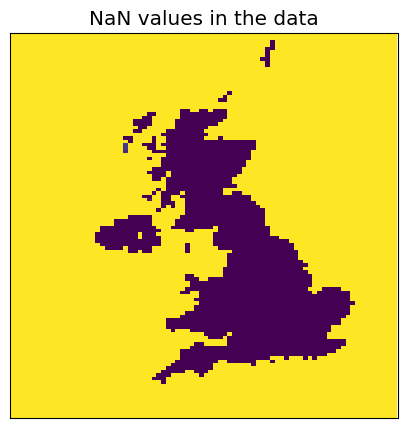

In [31]:
import matplotlib.pyplot as plt

temperature_data = data_temp['tas']

plt.figure(figsize=(5, 5))
ax = temperature_data.isnull().sum(dim='time').plot(add_colorbar=False)
plt.title('NaN values in the data')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

Where NaN is yellow and valid data is purple

The NaN values can be easily handled if you're not worried about the spatial aspect of the data. For example plotting the average temperature for the UK as a whole.

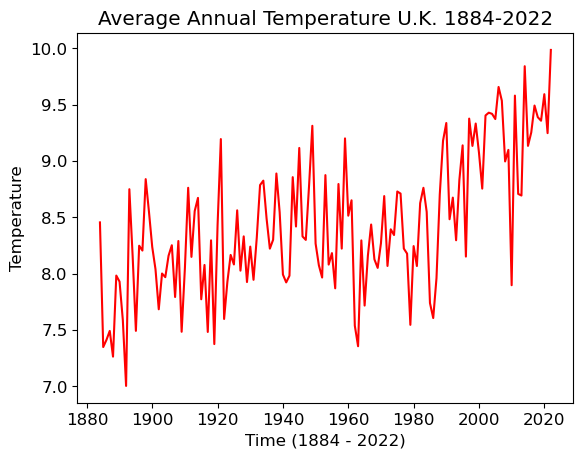

In [32]:
from skimage.measure import block_reduce
import numpy as np

# Block reduce cuts the data into blocks and applies a function to each block. In this case, the function is the mean and the block size is 12 months.
temp = block_reduce(data_all_months, block_size=(12,1,1), func=np.mean, cval=np.mean(data_all_months))

# The data is then averaged over the coordinate dimensions with nanmean being used to ignore NaN values.
temp_mean = np.nanmean(temp, axis=(1, 2))

time = np.arange(1884,2023)

plt.plot(time, temp_mean, 'r')
plt.xlabel('Time (1884 - 2022)')
plt.ylabel('Temperature')
plt.title('Average Annual Temperature U.K. 1884-2022')
plt.rcParams.update({'font.size': 12})

This can also be done if you want to create maps for different variables. Cartopy is a package that lets you create detailed maps and overlay your data onto them.

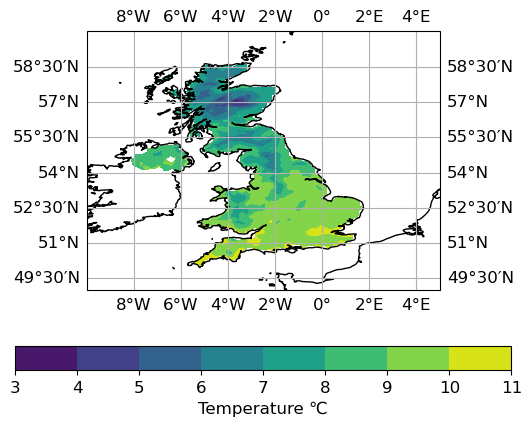

In [33]:
import cartopy.crs as ccrs

# The netcdf file contains the latitude and longitude values of the data but they are not within the actual data array.
lons = data.variables['longitude'][:]
lats = data.variables['latitude'][:]

# The mean temperature is calculated over the time dimension.
mean_temp = np.mean(data_all_months, axis=0)

plt.figure()

# Create a Cartopy projection with the desired extent
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map in latitude and longitude
ax.set_extent([-10, 5, 49, 60])

# Add coastlines and gridlines. These are predefined functions in Cartopy.
ax.coastlines(resolution='10m', color='black')
ax.gridlines(draw_labels=True, dms=True)

# Create a contour plot for the mean temperature field
contour = plt.contourf(lons, lats, mean_temp, cmap=plt.cm.viridis)

# Add a colorbar
cbar = plt.colorbar(contour, orientation='horizontal')
cbar.set_label(u"Temperature \u2103")

plt.show()

When you actually care about the spatial dimensions the NaN values are much trickier. One way to handle them is storing your data in a pandas dataframe and masking them out.

In [34]:
# Panda is a useful library for data manipulation and analysis. It can be used to create a DataFrame from the data.
import pandas as pd

# The data must be flattened to 1D to be used in a DataFrame
temp_flat = data_all_months.flatten()

# Create DataFrame
df = pd.DataFrame({
    'Temp': temp_flat,
})

In [35]:
df

,Temp
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
15318907,NaN
15318908,NaN
15318909,NaN
15318910,NaN


In [36]:
# List of columns to check for NaN values
columns_to_check = ['Temp']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [37]:
# This prints how many true and false values there are in the mask. True corresponds to NaN values being present.
print(nan_mask.value_counts())

True     12472541
False     2846371
Name: count, dtype: int64


As you can see there are far more NaN values than actual data points.

Now we can check the new df_filtered for NaN values.

In [38]:
# List of columns to check for NaN values
columns_to_check = ['Temp']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask_filtered = df_filtered[columns_to_check].isnull().any(axis=1)

In [39]:
# This prints how many true and false values there are in the mask. True corresponds to NaN values being present.
print(nan_mask_filtered.value_counts())

False    2846371
Name: count, dtype: int64


The NaN values have been succesfully filtered out.

In [40]:
df_filtered

,Temp
852,7.942743
932,8.190250
933,7.702709
934,7.530887
1015,7.908033
...,...
15318474,3.530120
15318556,3.465676
15318557,3.691931
15318639,3.181203


The issue now though is that you have a dataframe of a flattened array and various bits has been taken out. It is now very difficult (in my experience impossible) to reshape this data to be representative of the UK grid